## NN Adv Assignment

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
os.chdir('C:/Users/cts08/Tobigs19_work')

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [29]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [5]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [6]:
train['label'].nunique()

10

In [7]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,63,0,0,0,0,0,0,0


In [8]:
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

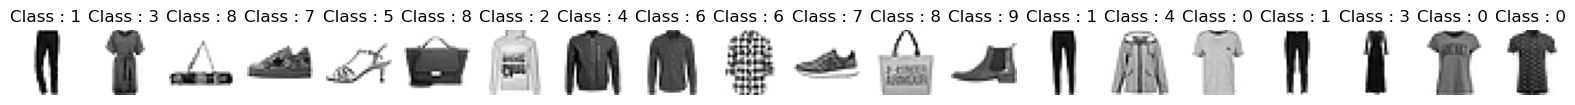

In [9]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
    plt.subplot(1, 20, idx + 1)
    plt.axis('off')
    plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
    plt.title(f'Class : {y[idx]}')

In [10]:
X_test = test.values

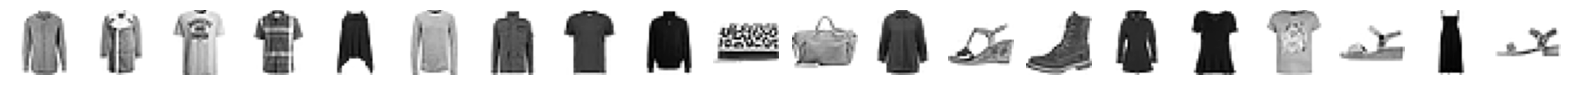

In [11]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
    plt.subplot(1, 20, idx + 1)
    plt.axis('off')
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization : 각각의 값들을 0과 1사이의 값으로 정규화 시켜주기 위해 255로 나누어줌.
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

# 각각의 train, val, test값들을 tensor로 변형시켜줌.

## NN Model

In [13]:
# 모델 설계에 앞서 필요한 환경 확인 및 세팅.

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print(DEVICE)

cpu


In [14]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
    def __init__(self, image, label = None):
        super(DataSet, self).__init__()
        self._image = image
        self._label = label

    def __len__(self):
        return len(self._image)

    def __getitem__(self, idx):
        if self._label is None:
            image = self._image[idx]
            return image
        else:
            image = self._image[idx]
            label = self._label[idx]
            return image, label

In [15]:
BATCH_SIZE = 128

train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [16]:
def train(model, train_loader):
    # 모델을 학습 모드로 전환
    model.train()
    train_loss = 0
    correct = 0

    for image, label in train_loader:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        # 학습 데이터를 DEVICE의 메모리로 보냄
        optimizer.zero_grad()
        # 매 반복마다 기울기를 계산하기 위해 zero_grad()를 호출
        output = model(image)
        loss = criterion(output, label)
        # output과 label(정답)과의 criterion으로 loss를 계산(10개의 클래스이므로 Cross Entropy 사용)
        loss.backward()
        # 기울기 계산(back propagation을 통해 gradient 계산)
        optimizer.step()
        # 가중치 수정

        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
      
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

In [17]:
def evaluate(model, test_loader):
    # 모델을 평가 모드로 전환
    model.eval()
    test_loss = 0 # test 과정에서의 loss
    correct = 0 # 실제 모델의 예측과 정답 맞은 횟수

    with torch.no_grad(): # 평가 과정에서는 기울기 계산이 이루어지지 않으므로 no_grad 설정
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            # 모든 오차의 합 구해줌
            test_loss += criterion(output, label).item() 
            # 가장 큰 값을 가진 클래스가 모델의 예측임
            # 예측 클래스(prediction)과 정답 클래스를 비교하여 일치하는 경우에 correct에 1을 더해줌.
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    # 정확도 계산
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [18]:
def pred(model, test_loader):
    # 모델을 평가 모드로 전환(예측을 위해)
    model.eval()
    pred_li = [] # 예측 데이터를 추가할 리스트 생성

    with torch.no_grad(): # 마찬가지로 기울기 계산이 이루어지지 않음
        for image in test_loader:
            image = image.to(DEVICE)
            output = model(image)
            pred_li.append(output.cpu().numpy().argmax(axis=1))

    return np.concatenate(pred_li)

기존의 baseline model의 최종 제출 코드를 먼저 살펴보도록 하자.
simple nn의 구조에서

* Activation Function 활용 : **relu**
* Weight Initialization 활용 : **he initialization**
* Batch Normalization 활용 : **learning rate = 0.01**
* Optimization 활용 : **Adam**
* Dropout 활용 : **0.2**

를 적절히 이용해 최종 model을 만들었다.  
(해당 모델의 구조를 주석을 통해 자세히 설명하였다.)

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 첫번째 Fully Connected layer(input -> 첫번째 은닉층)
        self.linear1 = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        # 두번째 Fully Connected layer(첫번째 은닉층 -> 두번째 은닉층)
        self.linear2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        # 세번째 Fully Connected layer(두번째 은닉층 -> 세번째 은닉층)
        self.linear3 = nn.Sequential(
            nn.Linear(256, 128), 
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        # 네번째 Fully Connected layer(세번째 은닉층 -> 출력층)
        self.linear4 = nn.Sequential(
            nn.Linear(128, 10)
        )

        self._init_weight_()

    def _init_weight_(self): # weight initialization
        for m in self.linear1:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight) # he initialization

        for m in self.linear2:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

        for m in self.linear3:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)

    def forward(self, x):
        # input data(image) = x
        # x.shape = torch.Size([64, 1, 28, 28])
        x = x.view(-1, 28 * 28)
        # x.shape = torch.Size([512, 784])
        x = self.linear1(x)
        # x.shape = torch.Size([256, 512])
        x = self.linear2(x)
        # x.shape = torch.Size([128, 256])
        x = self.linear3(x)
        # x.shape = torch.Size([10, 128])
        x = self.linear4(x)
        # 최종 10개의 각 클래스에 대한 값을 출력
        return x

In [20]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # 학습률을 0.01로 하여 Adam optimizer를 설정
criterion = nn.CrossEntropyLoss() # loss를 계산할 criterion을 Cross Entropy로 설정

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [19]:
result_list = []
EPOCHS = 30

for epoch in range(1, EPOCHS + 1):
    
    train_loss, train_accuracy = train(model, train_loader)
    val_loss, val_accuracy = evaluate(model, val_loader)
    
    if epoch % 5 == 0:
        print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
    
    result = {
        'EPOCH': epoch,
        'Train Loss': train_loss,
        'Train Accuracy': train_accuracy,
        'Val Loss': val_loss,
        'Val Accuracy': val_accuracy}
  
    result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 5], 	Train Loss: 0.3685, 	Train Accuracy: 86.43 %, 	Val Loss: 0.3408, 	Val Accuracy: 87.45 % 

[EPOCH: 10], 	Train Loss: 0.3186, 	Train Accuracy: 88.23 %, 	Val Loss: 0.3005, 	Val Accuracy: 88.59 % 

[EPOCH: 15], 	Train Loss: 0.2909, 	Train Accuracy: 89.04 %, 	Val Loss: 0.3127, 	Val Accuracy: 88.40 % 

[EPOCH: 20], 	Train Loss: 0.2679, 	Train Accuracy: 89.94 %, 	Val Loss: 0.3070, 	Val Accuracy: 89.29 % 

[EPOCH: 25], 	Train Loss: 0.2496, 	Train Accuracy: 90.57 %, 	Val Loss: 0.2858, 	Val Accuracy: 90.26 % 

[EPOCH: 30], 	Train Loss: 0.2298, 	Train Accuracy: 91.25 %, 	Val Loss: 0.2918, 	Val Accuracy: 89.68 % 



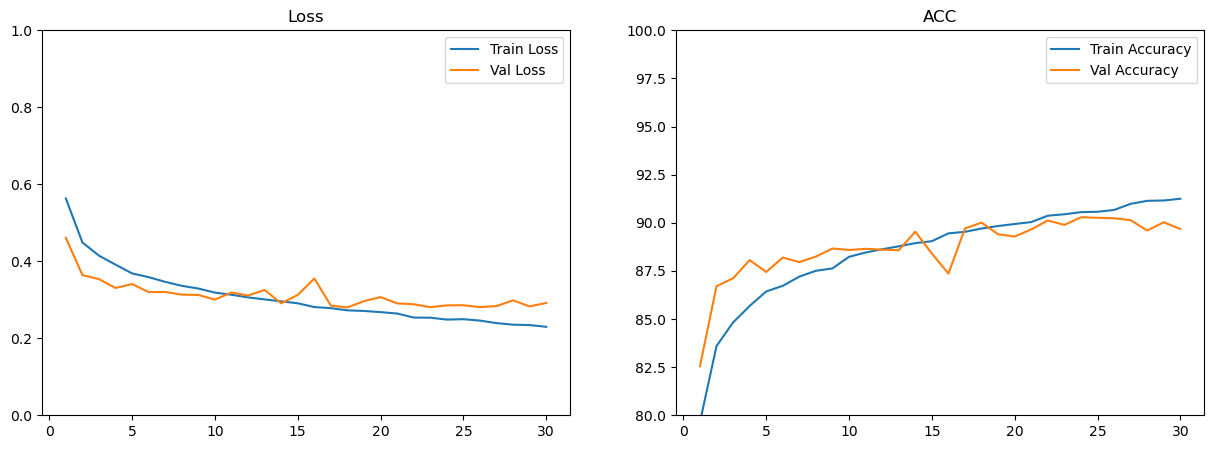

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## CNN Model

기본 Neural Network 방법에서 fashion 이미지 분류 모델의 향상을 위해 CNN모델을 구현하여 성능을 확인해보고자 한다.

In [21]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values
X_test = test.values

X.shape, y.shape, X_test.shape

((59500, 784), (59500,), (10500, 784))

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization : 각각의 값들을 0과 1사이의 값으로 정규화 시켜주기 위해 255로 나누어줌.
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

# 각각의 train, val, test값들을 tensor로 변형시켜줌.

위의 NN구조에서는 각 train, val, test들이 tensor의 크기로 28*28 = 784 값을 가졌는데 이를 28 28로 나누어 그 size를 [?(batch size),1(channel),28(height),28(width)]로 만들어준다.

In [23]:
X_train = X_train.view(-1,1,28,28)
X_val = X_val.view(-1,1,28,28)
X_test = X_test.view(-1,1,28,28)

BATCH_SIZE = 128

In [24]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

test_loader = DataLoader(X_test, batch_size=BATCH_SIZE)

In [25]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            # 1채널(흑백)을 입력받아 64개의 채널을 뽑아내고 kernel size를 (3,3) 정사각형구조로, 패딩을 1로 설정해줌.
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64), # 출력 채널의 64개 채널에 대해 정규화를 진행시켜줌.
            nn.ReLU(), # 활성화함수는 relu함수로 적용.
            nn.Conv2d(64, 128, 3, padding=1),  # (128, 28, 28)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),         # (128, 14, 14) - 풀링층으로 값을 2로 설정하여 특성맵이 절반의 크기로 다운샘플링 됨.
            
            
            # 위와 동일한 구조로 반복
            nn.Conv2d(128, 256, 3, padding=1), # (128, 14, 14)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), # (256, 14, 14)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                # (256, 7, 7)
            
            # 위와 동일한 구조로 반복
            nn.Conv2d(256, 512, 3),            # (512, 5, 5)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3),            # (512, 3, 3)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1),         # (512, 2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 128), # 전결합층 2*2*512 inputs -> 128 outputs
            nn.ReLU(),
            nn.Dropout(0.2), # dropout을 진행
            nn.Linear(128, 10), # 128 inputs -> 128 outputs
        )

    def forward(self, x):
        x = self.layer(x)
        x = x.view(x.size(0), -1) # 전결합층을 위해 view로 flatten 시켜줌.
        x = self.classifier(x)
        return x

model = ConvNet().to(DEVICE)

print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.01)

print(model)

Params to learn:
	 layer.0.weight
	 layer.0.bias
	 layer.1.weight
	 layer.1.bias
	 layer.3.weight
	 layer.3.bias
	 layer.4.weight
	 layer.4.bias
	 layer.7.weight
	 layer.7.bias
	 layer.8.weight
	 layer.8.bias
	 layer.10.weight
	 layer.10.bias
	 layer.11.weight
	 layer.11.bias
	 layer.14.weight
	 layer.14.bias
	 layer.15.weight
	 layer.15.bias
	 layer.17.weight
	 layer.17.bias
	 layer.18.weight
	 layer.18.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
ConvNet(
  (layer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, 

In [26]:
def train(model, train_loader):
    # 모델을 학습 모드로 전환
    model.train()
    train_loss = 0
    correct = 0

    for image, label in train_loader:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        # 학습 데이터를 DEVICE의 메모리로 보냄
        optimizer.zero_grad()
        # 매 반복마다 기울기를 계산하기 위해 zero_grad()를 호출
        output = model(image)
        loss = criterion(output, label)
        # output과 label(정답)과의 criterion으로 loss를 계산(10개의 클래스이므로 Cross Entropy 사용)
        loss.backward()
        # 기울기 계산(back propagation을 통해 gradient 계산)
        optimizer.step()
        # 가중치 수정

        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
      
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, train_accuracy

In [27]:
def evaluate(model, test_loader):
    # 모델을 평가 모드로 전환
    model.eval()
    test_loss = 0 # test 과정에서의 loss
    correct = 0 # 실제 모델의 예측과 정답 맞은 횟수

    with torch.no_grad(): # 평가 과정에서는 기울기 계산이 이루어지지 않으므로 no_grad 설정
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            # 모든 오차의 합 구해줌
            test_loss += criterion(output, label).item() 
            # 가장 큰 값을 가진 클래스가 모델의 예측임
            # 예측 클래스(prediction)과 정답 클래스를 비교하여 일치하는 경우에 correct에 1을 더해줌.
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    # 정확도 계산
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [12]:
result_list = []
EPOCHS = 30

for epoch in range(1, EPOCHS + 1):
    
    train_loss, train_accuracy = train(model, train_loader)
    val_loss, val_accuracy = evaluate(model, val_loader)
    
    if epoch % 5 == 0:
        print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
    
    result = {
        'EPOCH': epoch,
        'Train Loss': train_loss,
        'Train Accuracy': train_accuracy,
        'Val Loss': val_loss,
        'Val Accuracy': val_accuracy}
  
    result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 5], 	Train Loss: 0.2807, 	Train Accuracy: 90.11 %, 	Val Loss: 0.2330, 	Val Accuracy: 91.94 % 

[EPOCH: 10], 	Train Loss: 0.1865, 	Train Accuracy: 93.53 %, 	Val Loss: 0.2417, 	Val Accuracy: 92.23 % 

[EPOCH: 15], 	Train Loss: 0.1156, 	Train Accuracy: 95.87 %, 	Val Loss: 0.3210, 	Val Accuracy: 92.04 % 

[EPOCH: 20], 	Train Loss: 0.0806, 	Train Accuracy: 97.29 %, 	Val Loss: 0.3808, 	Val Accuracy: 92.44 % 

[EPOCH: 25], 	Train Loss: 0.0557, 	Train Accuracy: 98.21 %, 	Val Loss: 0.4278, 	Val Accuracy: 93.00 % 

[EPOCH: 30], 	Train Loss: 0.0504, 	Train Accuracy: 98.51 %, 	Val Loss: 0.4652, 	Val Accuracy: 92.91 % 



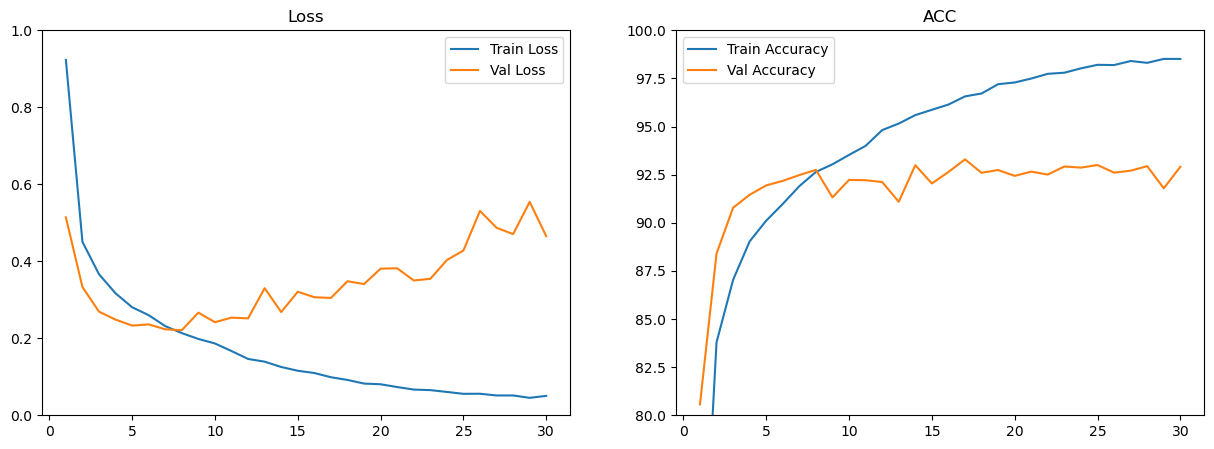

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

확실히 CNN Model의 경우 그 정확도가 92.91%로 기존의 NN Model의 89.68%보다 더욱 높은 정확도를 보이고 있다.

## 추가 사항

최종 결과 그래프를 해석해보겠다.
일반적으로 학습이 잘 되고 있다고 함은 loss가 epoch가 올라감 train과 val에서 모두 감소하는 경향을 보여야 하지만 val loss의 값은 일정 epoch에 도달한 이후부터 점차 상승하는 그래프를 보였다. 따라서 훈련이 잘 되지 않으며 overfitting이 일어났다고 할 수 있다.  
이러한 방법을 해결하기 위해 validation set을 이용하거나 early stop을 통해 overfitting이 일어나기 전에 조기 종료 시킴으로써 과적합을 방지할 수 있을 것이다.